This notebook is the primary notebook for the project where we bring the final code together.

#Install packages and import libraries

In [ ]:
pip install stargazer

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
install.packages("bacondecomp")

In [ ]:
%%R
#https://stackoverflow.com/questions/24094476/python-pandas-to-r-dataframe
install.packages("feather")

In [ ]:
# This cell takes about 9 minutes to run
%%R
install.packages("did")

In [ ]:
%%R
devtools::install_github("kylebutts/didimputation")

In [ ]:
%%R
library(tidyverse)
#> ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
#> ✓ ggplot2 3.3.5     ✓ purrr   0.3.4
#> ✓ tibble  3.1.3     ✓ dplyr   1.0.7
#> ✓ tidyr   1.1.3     ✓ stringr 1.4.0
#> ✓ readr   2.0.0     ✓ forcats 0.5.1
#> ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
#> x dplyr::filter() masks stats::filter()
#> x dplyr::lag()    masks stats::lag()
library(didimputation)
#> Loading required package: fixest

library(fixest)

In [ ]:
pip install geopandas

In [ ]:
pip install shap

In [ ]:
pip install git+https://github.com/microsoft/dowhy.git

In [ ]:
pip install econml

In [ ]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import statsmodels.api as sm 
import statsmodels.formula.api as smf 
from itertools import combinations 
import plotnine as p
from datetime import datetime
import datetime
import math
from itertools import cycle
from google.colab import files
from stargazer.stargazer import Stargazer
import shap
import plotly.express as px
import altair as alt
import geopandas as gpd
from shapely import affinity
from shapely.geometry import mapping, shape
from bokeh.io import output_notebook
from bokeh.layouts import column
from bokeh.models import LogColorMapper, FixedTicker, ColorBar, GeoJSONDataSource, HoverTool, Slider, CustomJS
from bokeh.palettes import Blues7 as palette
from bokeh.plotting import figure, show
from sklearn.datasets import make_regression
from dowhy import CausalModel
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
pd.set_option('display.max_columns', None) #uncomment if you want to see all the columns of a df when you print it
# pd.set_option('display.max_rows', None) #uncomment if you want to see all the rows of a df when you print it
from sklearn.model_selection import GridSearchCV
from econml.dml import DML, LinearDML, CausalForestDML, NonParamDML
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from econml.cate_interpreter import SingleTreeCateInterpreter


#Upload data sets for law, demographics, maps and CSA

In [ ]:
uploaded = files.upload()

In [ ]:
c = pd.read_csv('legaldata.csv')

In [ ]:
demographic_df = pd.read_excel('Demographics_state_v2.xlsx')

In [ ]:
csa_df = pd.read_csv('final_csa_all_y.csv')

#Clean up and format legal data

In [ ]:
c = c.iloc[:,:-1]

In [ ]:
columns = ['Effective Date','Screening Date Enacted','Criminalization Date Enacted']  #the columns that needed the date converted to datetime
for a in columns:
    c[a] = c[a].apply(lambda x: datetime.datetime.strptime(str(x), "%m-%y'").date() if "'" in str(x) else x) #convert string to datetime

In [ ]:
c.replace('NAN',np.nan, inplace = True) #converting string NAN to np.nan
c['STATE'] = c['STATE'].str.replace('\r\n', '', regex=False)


In [ ]:
c.dropna(axis=0, how='all', inplace = True) #dropping empty rows

In [ ]:
newdf = pd.DataFrame(np.repeat(c.values, 15, axis=0)) #replicate each row 15 times 
newdf.columns = c.columns


In [ ]:
seq = cycle([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019])
newdf['yrs'] = [next(seq) for count in range(newdf.shape[0])] #create a new column which is filled by iterating through 2005-2019 year range 

In [ ]:
#little messy but the logic is check if value in row is a datetime (so not nan or a string)
#if datetime date comes after the year we are looking at currently
#convert all the corresponding values to 0

for x in range(0,len(newdf)):
    if isinstance(newdf['Effective Date'][x],datetime.date) == True:
        if (newdf['Effective Date'][x].year > newdf['yrs'][x]) == True:
            newdf.iloc[x,2:20] = 0 
        elif (newdf['Effective Date'][x].year == newdf['yrs'][x]) and (newdf['Effective Date'][x].month > 6):
            newdf.iloc[x,2:20] = 0
    if isinstance(newdf['Screening Date Enacted'][x],datetime.date) == True:
        if (newdf['Screening Date Enacted'][x].year >  newdf['yrs'][x]) == True:
            newdf.iloc[x,21] = 0
        elif (newdf['Screening Date Enacted'][x].year ==  newdf['yrs'][x]) and (newdf['Screening Date Enacted'][x].month > 6):
            newdf.iloc[x,21] = 0
    if isinstance(newdf['Criminalization Date Enacted'][x],datetime.date) == True:
        if (newdf['Criminalization Date Enacted'][x].year >  newdf['yrs'][x]) == True:
            newdf.iloc[x,23] = 0
        elif (newdf['Criminalization Date Enacted'][x].year ==  newdf['yrs'][x]) and (newdf['Criminalization Date Enacted'][x].month > 6):
            newdf.iloc[x,23] = 0
    if isinstance(newdf['Task Force Year Enacted'][x],str) == True:
        if (int(newdf['Task Force Year Enacted'][x]) >  newdf['yrs'][x]) == True:
            newdf.iloc[x,25] = 0
    if isinstance(newdf['Poster Year Enacted'][x],str) == True:
        if (int(newdf['Poster Year Enacted'][x]) >  newdf['yrs'][x]) == True:
            newdf.iloc[x,27] = 0



In [ ]:
n = 15  #chunk row size
list_df = [newdf[i:i+n] for i in range(0,newdf.shape[0],n)] #chunking dataframe into smaller dataframes for each state

#Add data for trends

In [ ]:
#my implementation of the "trend" columns in the Cunningham notebook. Pretty much just broke the dataframe into chunks, created a new column in each one which is the trend column
#and then appended the chunks back together to create the final dataframe
for i in range(0,len(list_df)):
    list_df[i][f'trend_{i}'] = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] 
    

trenddf = pd.DataFrame().append(list_df)

In [ ]:
#filling nan's with 0 for the trend columns

trenddf[list(trenddf.columns[30:])] = trenddf[list(trenddf.columns[30:])].fillna(0)

In [ ]:
trenddf.drop(list(range(71,86)), axis = 0, inplace = True) #dropped overlapping rows from California

In [ ]:
trenddf.drop(list(range(225,240)), axis = 0, inplace = True) #dropped overlapping rows from Illinois

In [ ]:
trenddf.drop(list(range(253,268)), axis = 0, inplace = True) #dropped overlapping rows from Indiana

In [ ]:
#dropped duplicate columns and renamed trend columns
trenddf['trend_4'] = trenddf['trend_4'] + trenddf['trend_5'] 
trenddf['trend_16'] = trenddf['trend_16'] + trenddf['trend_17']
trenddf.drop(columns = ['trend_5','trend_15','trend_17'], inplace = True)


In [ ]:
d = dict(zip(trenddf.columns[30:], trenddf['STATE'].unique() + '_' + 'trend')) #dictionary to replace column trend numbers with state names
trenddf.rename(columns = d, inplace = True)

In [ ]:
#add state ID
trenddf['sid'] = trenddf.groupby(['STATE']).ngroup()


In [ ]:
trenddf.columns = trenddf.columns.str.strip().str.replace('\r\n', '', regex=False).str.replace(" ", "_")
trenddf.head()

In [ ]:
trenddf.info(verbose = True, null_counts = True)

# Clean and add demographic data

In [ ]:
# drop unnamed column and rename variable to match with other datasets
demographic_df.drop(columns=['Unnamed: 0'], inplace=True)
demographic_df.rename(columns={'State':'STATE', 'Year':'yrs'}, inplace=True)
demographic_df['STATE'].replace({'D.C.':'District of Columbia'}, inplace = True)

# Add in missing DC data
dc_mean_pop = [567136,570681,574404,580236,592228,605226,619800, 634924,650581,662328,675400,685815,694906,701547,705749]
dc_unemp_rate = [6.4,5.8,5.5,6.5,9.3,9.4,10.2,9.0,8.5,7.8,6.9,6.1,6.1,5.6,5.3]
demographic_df.iloc[120:135,3] = dc_mean_pop
demographic_df.iloc[120:135,4] = dc_unemp_rate

demographic_df

In [ ]:
# Check for missing values
are_there_nans = demographic_df.isnull().values.any()

if are_there_nans == True:
  for column in demographic_df.columns:
    print(column, demographic_df[column].isnull().sum())

In [ ]:
# Open population data by state
pop = pd.read_excel('Population_state_lvl.xlsx',)
pop.rename(columns={'Area':'State'}, inplace=True)
pop = pop.set_index('State')

# Make a copy of the dataset (NOT averaged) for visualization
pop_not_avg = pop.copy()

# Reset the index
pop_not_avg.reset_index(inplace=True)

# Use stack to convert df to only 1 column 
pop_not_avg = pd.DataFrame(pop_not_avg.set_index('State').stack())

# Reset index, and fix column names
pop_not_avg.reset_index(inplace=True)
pop_not_avg.rename(columns={'State':'STATE', 'level_1':'yrs', 0:'pop'}, inplace=True)

pop_not_avg

In [ ]:
# Merge the demographic dataframe with the population not avg df
demographic_df = pop_not_avg.merge(demographic_df, on=['STATE', 'yrs'], how='left')
demographic_df

In [ ]:
# Merge the demographic dataframe with the trend_df
demographic_and_trend_df = trenddf.merge(demographic_df, on=['STATE', 'yrs'], how='left')
demographic_and_trend_df

In [ ]:
# Check for missing values
are_there_nans = demographic_and_trend_df.isnull().values.any()

if are_there_nans == True:
  for column in demographic_and_trend_df.columns:
    print(column, demographic_and_trend_df[column].isnull().sum())

#Clean and add CSA data

In [ ]:
df = demographic_and_trend_df.copy()


In [ ]:
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [ ]:
csa_df['staterr'].replace(abbrev_to_us_state, inplace = True) #converted two letter state abbrevations to full names to match the trend_df 
csa_df.rename({'subyr':'yrs', 'staterr':'STATE'}, axis = 1, inplace = True) #cleaned up column names

In [ ]:
csa_df['subst_repo_ratio'] = csa_df['reported_csa_cases']/csa_df['csa_cases']
csa_df['STATE'].value_counts() #XX is not something I found in the codebook but I assume it means the state wasn't recorded. 


In [ ]:
df = df.merge(csa_df, left_on = ['yrs','STATE'], right_on = ['yrs','STATE'], how = 'left') #left join demographic/trend df with csa data on year and state
df.sample(20)

In [ ]:
#filling data for Maryland and Michigan
df['csa_cases'][301] = (df['csa_cases'][300] + df['csa_cases'][299])/2 
df['csa_cases'][332] = (df['csa_cases'][331] + df['csa_cases'][330])/2 

df[df['csa_cases'].isnull()][['STATE','yrs']]




In [ ]:
df['all_cases'][301] = (df['all_cases'][300] + df['all_cases'][299])/2 
df['all_cases'][332] = (df['all_cases'][331] + df['all_cases'][330])/2 

df['reported_csa_cases'][301] = (df['reported_csa_cases'][300] + df['reported_csa_cases'][299])/2 
df['reported_csa_cases'][332] = (df['reported_csa_cases'][331] + df['reported_csa_cases'][330])/2 

df['subst_repo_ratio'][301] = (df['subst_repo_ratio'][300] + df['subst_repo_ratio'][299])/2 
df['subst_repo_ratio'][332] = (df['subst_repo_ratio'][331] + df['subst_repo_ratio'][330])/2 

In [ ]:
df['PK_5'] = df[['PK','K','Grade_1','Grade_2','Grade_3','Grade_4','Grade_5']].sum(axis = 1)
df['6_12'] = df[['Grade_6','Grade_7','Grade__8','Grade_9','Grade_10','Grade_11','Grade_12']].sum(axis = 1)
df['PK_5'] = df['PK_5'].apply(lambda x: 1 if x >= 4 else 0)
df['6_12'] = df['6_12'].apply(lambda x: 1 if x >= 4 else 0)

#DF Updates for analysis

In [ ]:
df.columns

In [ ]:
df.head()

In [ ]:
#remember to create columns for post and popwt
df = df.rename(columns={'Year_Binary': "post", 'mean_pop': 'popwt', 'yrs': 'year', 'Some/All_Staff': 'Some_All_Staff', 'Opt-Out': 'Opt_Out', '6_12':  'G6_12','csa_cases':'sub_csa_cases','all_cases':'sub_ca_cases','reported_csa_cases':'rep_csa_cases','subst_repo_ratio':'sub_rep_csa_ratio'})

In [ ]:
df = df[df['sid']!=37] #drop Oregon rows

In [ ]:
df = df[df['sid']!=34] #drop North Dakota rows

In [ ]:
#to set up auto regression of sorts, normalized first difference
def auto(lst):
  new_lst = []
  new_lst.append(0)
  for i in range(1, len(lst)):
    temp = (lst[i-1] - lst[i]) / lst[i-1]
    new_lst.append(temp)
  return new_lst


In [ ]:
#create column for sub_csa_yc

df = pd.concat([df.reset_index(),df.groupby(['STATE'])['sub_csa_cases'].apply(list).map(auto).explode().reset_index().rename({'sub_csa_cases':'sub_csa_yc'}, axis = 1)['sub_csa_yc']], axis = 1) #convert state csa values into a list to then modify using above function. Explode lists back out into rows and concat back with original df


In [ ]:
#create column for sub_ca_yc
df = pd.concat([df, df.groupby(['STATE'])['sub_ca_cases'].apply(list).map(auto).explode().reset_index().rename({'sub_ca_cases':'sub_ca_yc'}, axis = 1)['sub_ca_yc']], axis = 1) #same as above with reported csa cases

In [ ]:
df['sub_csa_yc'] = df['sub_csa_yc'].astype(float)
df['sub_ca_yc'] = df['sub_ca_yc'].astype(float)
df.info(verbose = True) #CSA column has 508 values which lines up with (51 states/territories * 10 years) - 2 unaccounted for in Oregon which I will take a look at

In [ ]:
miss_df = pd.read_csv(r'missing_reports.csv')

In [ ]:
miss_df

In [ ]:
df = df.merge(miss_df, how = 'left',left_on = ['STATE','year'], right_on = ['state','subyr']).drop(['state','subyr'], axis = 1)


In [ ]:
df.rename({'percent':'rep_csa_inc'}, axis = 1, inplace = True)

In [ ]:
df['rep_csa_inc'].fillna(0, inplace = True)
df


#Visualizations of the raw data to understand trends, etc.

##Legal data visualizations

###Rate of adoption of various csa laws

In [ ]:
#summary of CSA laws being passed in the US


viz1 = pd.DataFrame(['CSA Prevention Education in Schools','Screening/Dismissal of School Employees to Prevent CSA','Criminalizing Educator Sexual Misconduct','State Task Forces on Child Sexual Abuse','Student Safety Posters'])
viz1 = pd.concat([viz1]*2, ignore_index=True)
viz1['num'] = [34,11,39,24,35,17,40,12,27,16]
viz1['Law Enacted'] = ['Passed Law','Passed Law','Passed Law','Passed Law','Passed Law','No Law in Effect','No Law in Effect','No Law in Effect','No Law in Effect','No Law in Effect']
plot_order = ['Criminalizing Educator Sexual Misconduct','Student Safety Posters','CSA Prevention Education in Schools','State Task Forces on Child Sexual Abuse','Screening/Dismissal of School Employees to Prevent CSA']

g = sns.histplot(data = viz1.iloc[::-1,:], x = 0, weights = 'num', hue = 'Law Enacted', multiple = 'stack', palette="dark")


plt.ylabel("Number of States")
plt.xlabel('')
plt.title("Number of States With Enacted CSA Prevention Laws", fontsize=15, fontdict={"weight": "bold"})
plt.xticks(rotation=90)
plt.ylim(0,51)
sns.move_legend(g, "lower center", bbox_to_anchor=(1.4, .5), ncol=2, title_fontsize=14)

In [ ]:
c['Screening Date Enacted'].loc[49] = pd.to_datetime(2021,format='%Y')
c['Screening Date Enacted'].loc[57] = pd.to_datetime(2011, format='%Y')
c['Screening Date Enacted'] = pd.to_datetime(c['Screening Date Enacted'])
c['Effective Date'] = pd.to_datetime(c['Effective Date'])
c['Criminalization Date Enacted'] = pd.to_datetime(c['Criminalization Date Enacted'])

ed = c.groupby(c['Effective Date'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Effective Date']), left_on = 'Effective Date', right_on = 'Effective Date', how = 'outer').fillna(0).sort_values('Effective Date')['STATE'].cumsum().tolist()
cd = c.groupby(c['Criminalization Date Enacted'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Criminalization Date Enacted']), left_on = 'Criminalization Date Enacted', right_on = 'Criminalization Date Enacted', how = 'outer').fillna(0).sort_values('Criminalization Date Enacted')['STATE'].cumsum().tolist()[4:]
sd = c.groupby(c['Screening Date Enacted'].dt.year).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Screening Date Enacted']), left_on = 'Screening Date Enacted', right_on = 'Screening Date Enacted', how = 'outer').fillna(0).sort_values('Screening Date Enacted')['STATE'].cumsum().tolist()[1:]
tf = c.groupby(c['Task Force Year Enacted']).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Task Force Year Enacted']), left_on = 'Task Force Year Enacted', right_on = 'Task Force Year Enacted', how = 'outer').fillna(0).sort_values('Task Force Year Enacted')['STATE'].cumsum().tolist()
sp = c.groupby(c['Poster Year Enacted']).count()['STATE'].reset_index().astype(int).merge(pd.DataFrame(list(range(2009,2022)), columns = ['Poster Year Enacted']), left_on = 'Poster Year Enacted', right_on = 'Poster Year Enacted', how = 'outer').fillna(0).sort_values('Poster Year Enacted')['STATE'].cumsum().tolist()

years = list(range(2009, 2022))
data_preproc = pd.DataFrame({
    'Year': years, 
    'Education Laws': ed,
    'Criminalization': cd,
    'Task Force': tf,
    'Safety Posters': sp,
    'Screening Laws':sd})

ax = sns.lineplot(x='Year', y='value', hue='variable', 
             data=pd.melt(data_preproc, ['Year']))


h,l = ax.get_legend_handles_labels()
plt.legend(h,l, loc='upper left',
           fancybox=True, shadow=True)
ax.set_title('Cumulative Count of CSA Prevention Laws Enacted By States 2009-2021')
ax.set_ylim(-1,51)
ax.set_xlim(2009, 2021)



In [ ]:
order = list(c.sort_values('Effective Date').STATE.unique())

viz2 = trenddf.copy()

viz2['Year_Binary'].replace({1:5}, inplace = True)
viz2['Criminalization'].replace({1:2}, inplace = True)
viz2['Screening'].replace({1:3}, inplace = True)
viz2['Task_Force'].replace({1:4}, inplace = True)
viz2['Posters'].replace({1:1}, inplace = True)


viz2 = pd.DataFrame(np.concatenate((viz2[['STATE','yrs','Posters']],np.concatenate((viz2[['STATE','yrs','Task_Force']],np.concatenate((viz2[['STATE','yrs','Screening']], np.concatenate( (viz2[['STATE','yrs','Year_Binary']].values,viz2[['STATE','yrs','Criminalization']].values), axis=0 ) )))))))
viz2[2] = viz2[2].astype(int)

def label_race (row):
    if row[2] == 1 :
        return 'Education Law'
    if row[2] == 2 :
        return 'Criminalization'
    if row[2] == 3:
        return 'Educator Screening'
    if row[2]  == 4:
        return 'Task Force'
    if row[2] == 5:
        return 'Safety Posters'
    return None

viz2[3] = viz2.apply (lambda row: label_race(row), axis=1)
viz2.rename({0:'STATE',1:'YEAR',2:'VALUE',3:'LABEL'}, axis = 1, inplace = True)



# Create the dictionary that defines the order for sorting
sorterIndex = dict(zip(order, range(len(order))))

# Generate a rank column that will be used to sort
# the dataframe numerically
viz2['Tm_Rank'] = viz2['STATE'].map(sorterIndex)

# Here is the result asked with the lexicographic sort
# Result may be hard to analyze, so a second sorting is
# proposed next
## NOTE: 
## Newer versions of pandas use 'sort_values' instead of 'sort'
viz2.sort_values(['Tm_Rank','YEAR'],
        ascending = [True, True], inplace = True)
viz2.drop('Tm_Rank', 1, inplace = True)
viz2

In [ ]:
from google.colab import files
hd = {'LABEL':True,'YEAR':True,'VALUE':False,'STATE':False}

fig = px.scatter_polar(viz2, r='VALUE', theta='STATE',
                       color='VALUE',animation_frame='YEAR', width = 900, height = 900, color_continuous_scale = ['#6741a1','#ebb045','#094c94','#76af31','#c20078'], 
                       range_color = [0,5.5], range_r = [0,6]) 
                      #  hover_data = hd)

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2)),
                  selector=dict(mode='markers'))
fig.update(layout_coloraxis_showscale=False)
fig.update(layout_showlegend=True)

fig.update_layout(
    template="ggplot2",
    polar = dict(
        radialaxis = dict(showticklabels=False, ticks=''),
        angularaxis = dict(showticklabels=True, ticks='')),
        title = 'Enactment of CSA Laws by State: 2005-2019',)

fig.show()

fig.write_html("CSA_law_enactment_interactive.html")
files.download("CSA_law_enactment_interactive.html")


In [ ]:
# Uncomment if you want to export the interactive visualization
# fig.write_html("adoption_of_csa_laws.html") 

###Type of csa educational laws

In [ ]:
#nature of education laws in terms of required, etc

# Make copy of main df
require_vis_df = df[['STATE', 'year', 'Required', 'Opt_Out', 'Some_All_Staff', 'PK_5',	'G6_12']].copy()

# Set variable to the number of states & territories in df
num_states = len(require_vis_df.STATE.unique())

# Drop state, change df to int, and groupby year
require_vis_df.drop(columns=['STATE'], inplace=True)
require_vis_df = require_vis_df.astype('int32')
require_vis_df = require_vis_df.groupby(['year']).sum().reset_index()

# Calculate the percentage for each of the variables
require_vis_df['%_required'] = (require_vis_df['Required'] / num_states) * 100
require_vis_df['%_opt_out'] = (require_vis_df['Opt_Out'] / num_states) * 100
require_vis_df['%_Some/All_Staff'] = (require_vis_df['Some_All_Staff'] / num_states) * 100
require_vis_df['%_PK_5'] = (require_vis_df['PK_5'] / num_states) * 100
require_vis_df['%_6_12'] = (require_vis_df['G6_12'] / num_states) * 100

# Plot each line
plt.plot(require_vis_df['year'], require_vis_df['%_required'], label = "Required")
plt.plot(require_vis_df['year'], require_vis_df['%_opt_out'], label = "Opt_Out")
plt.plot(require_vis_df['year'], require_vis_df['%_Some/All_Staff'], label = "Some/All_Staff")
plt.plot(require_vis_df['year'], require_vis_df['%_PK_5'], label = "PK - Grade 5")
plt.plot(require_vis_df['year'], require_vis_df['%_6_12'], label = "Grade 6 - 12")

# Fix x-axis lables, set title and axis labels
xlabels = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
plt.title("Percent of States and Their CSA Education Legal Requirements")
plt.xlabel('Year')
plt.ylabel('Percent of States & US Territories (n=51)')
plt.xticks(require_vis_df['year'], xlabels, rotation='vertical')

# Uncomment below 2 lines if you would prefer the y-axis go to 100%
# x1,x2,y1,y2 = plt.axis()  
# plt.axis((x1,x2,0,100))

# Add legend and show the plot
plt.legend()
plt.show()

# Also show the df so reader can see specific percentages
require_vis_df.head(15)

## Y-Value/CSA Visualizations


### y = sub_csa_cases

In [ ]:
# Substantiated Cases overtime in all states

# Create subset of main df and format
sub_vis_df = df[['STATE', 'year', 'sub_csa_cases']].copy()
sub_vis_df['year'] = sub_vis_df['year'].apply(str)
avg_line3 = sub_vis_df.groupby('year').mean().reset_index()
avg_line3['Legend'] = 'Average'

color_range = ['lightgray']

# Create the main plot lines
sub_vis_plot = alt.Chart(sub_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add blue line for average
y_line = alt.Chart(avg_line3).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_csa_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine main plot with average line
final_sub_vis = sub_vis_plot + y_line

# Set title
final_sub_vis.properties(
    title = {
      "text": ["Substantiated Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )


In [ ]:
# Visual of the first 6 states to enact the law
# black line is the year enacted

# Pull out only the first 6 states to enact the law
top_6_states = ['Texas', 'Vermont', 'Michigan', 'Indiana', 'Illinois', 'Mississippi']
top_6_df = df[['STATE', 'year', 'Effective_Date', 'sub_csa_cases']].copy()

# Create a smaller subset of main df and format
top_6_df = top_6_df[top_6_df['STATE'].isin(top_6_states)]
top_6_df['Year'] = pd.to_datetime(top_6_df['Effective_Date']).dt.year
top_6_df['year'] = top_6_df['year'].apply(str)

# Create a function that will create a line chart for a given state
def create_chart(state):
  df = top_6_df[top_6_df['STATE'] == state]
  enact_year = df['Year'].iloc[0]
  df['ey'] = enact_year
  df['ey'] = df['ey'].apply(str)
  df['Legend'] = 'Year Law is Effective'

  df_chart = alt.Chart(df[['year','sub_csa_cases']]).mark_line().encode(
      x=alt.X('year', title='Year'),
      y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
  )

  df_rule = alt.Chart(df[['ey','Legend']]).mark_rule().encode(
      x='ey',
      size=alt.value(2),
      opacity=alt.Opacity('Legend', legend=alt.Legend(title="Legend"))
  )

  final_vis = df_chart + df_rule
  final_vis = final_vis.properties(title=f'{state}', height=200, width=250)

  return final_vis

# Create a plot for each of the top 6 states
texas_vis = create_chart('Texas')
vermont_vis = create_chart('Vermont')
michigan_vis = create_chart('Michigan')

indiana_vis = create_chart('Indiana')
illinois_vis = create_chart('Illinois')
miss_vis = create_chart('Mississippi')

# hconcat the state visuals into rows
row1 = texas_vis | vermont_vis | michigan_vis
row2 = indiana_vis | illinois_vis | miss_vis

# vconcat the rows to create a small multiples plot
final = (row1 & row2).properties(
    title='Number of CSA Cases Over Time in the First 6 States to Enforce a Law'
    ).configure_title(anchor='middle', fontSize=15,)

# Show the visual    
final

###y = rep_csa_cases

In [ ]:
# Create a visual of the reported csa cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'rep_csa_cases']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line_rcc = y_vis_df.groupby('year').mean().reset_index()
avg_line_rcc['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('rep_csa_cases', title='Reported CSA cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_rcc).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('rep_csa_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Reported CSA Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

### y = sub_ca_cases

In [ ]:
# Create a visual of all cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_ca_cases']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line_ac = y_vis_df.groupby('year').mean().reset_index()
avg_line_ac['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_ca_cases', title='All Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_ac).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_ca_cases'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["All Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

###y = sub_rep_csa_ratio

In [ ]:
# Create a visual of ratio of reported to substantiated cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_rep_csa_ratio']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
avg_line = y_vis_df.groupby('year').mean().reset_index()
avg_line['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_rep_csa_ratio', title='Ratio of Reported to Substantiated Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_rep_csa_ratio'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Ratio of Reported to Substantiated Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

In [ ]:
# Same visual as above but with only states that have a year_enacted date

# Create smaller subset of main df and format it appropriately 
y_vis2_df = df[['STATE', 'Effective_Date', 'year', 'sub_rep_csa_ratio']].copy() #changed year enacted to effective date
y_vis2_df.dropna(subset=['Effective_Date'], inplace=True)
y_vis2_df['year'] = y_vis2_df['year'].apply(str)
y_vis2_df['Year'] = pd.to_datetime(y_vis2_df['Effective_Date']).dt.year

# Drop any states with year enacted as 2019 or 2020 - to short to see difference
y_vis2_df = y_vis2_df[~y_vis2_df['Year'].isin([2019, 2020])]

# Create the average line
avg_line2 = y_vis2_df.groupby('year').mean().reset_index()
avg_line2['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the main lines
y_plot = alt.Chart(y_vis2_df[['year','sub_rep_csa_ratio','STATE']]).mark_line().encode(
    x=alt.X('year',title='Year'),
    y=alt.Y('sub_rep_csa_ratio', title='Ratio of Reported to Substantiated Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it\
)

# Plot the average line
y_line = alt.Chart(avg_line2).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_rep_csa_ratio'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the plot with the average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Ratio of Reported to Substantiated Cases Over Time"], 
      "subtitle": ["Only States With a CSA Law"]}
    )


###y = sub_csa_yc

In [ ]:
# Create a visual of csa cases Yearly change metric over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_csa_yc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df.dropna(inplace=True) #### DROP LINE WHEN NANS FIXED
y_vis_df['sub_csa_yc'] = y_vis_df['sub_csa_yc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_csa_yc', title='CSA Cases Yearly Change Metric'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_csa_yc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["CSA Cases Yearly Change Metric Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

###y = sub_ca_yc

In [ ]:
# Create a visual of substantiated CSA cases yearly change metric over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'sub_ca_yc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df['sub_ca_yc'] = y_vis_df['sub_ca_yc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('sub_ca_yc', title='Substantiated CA Cases Yearly Change Metric'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('sub_ca_yc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Substantiated CA Cases Yearly Change Metric Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

###y = rep_csa_inc

In [ ]:
# Create a visual of incompletely reviewed CSA cases over time

# create smaller subset of main df
y_vis_df = df[['STATE', 'year', 'rep_csa_inc']].copy()
y_vis_df['year'] = y_vis_df['year'].apply(str)
y_vis_df['rep_csa_inc'] = y_vis_df['rep_csa_inc'].apply(float)

avg_line_car = y_vis_df.groupby('year').mean().reset_index()
avg_line_car['Legend'] = 'Average'

color_range = ['lightgray']

# Plot the lines
y_plot = alt.Chart(y_vis_df).mark_line().encode(
    x=alt.X('year', title='Year'),
    y=alt.Y('rep_csa_inc', title='Number of Incompletely Reviewed CSA Cases'),
    color=alt.Color('STATE', legend=None, scale=alt.Scale(range=color_range)), # Delete legend=None if you want to see it - To noisy so I hid it
)

# Add a blue trend/average line
y_line = alt.Chart(avg_line_car).mark_line(strokeWidth=5).encode(
      x=alt.X('year'),
      y=alt.Y('rep_csa_inc'),
      shape=alt.Shape('Legend', legend=alt.Legend(title="Legend"))
  )

# Combine the lines with the blue trend/average line
final_y_vis = y_plot + y_line

# Set title
final_y_vis.properties(
    title = {
      "text": ["Number of Incompletely Reviewed CSA Cases Over Time"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

## Demographic Visualizations

### Population Visualization

In [ ]:
from bokeh.layouts import column
from bokeh.plotting import figure, output_file, save


In [ ]:
# Command called that allows you to open your Bokeh visuals inside of the notebook
output_notebook()

In [ ]:
# Import shapefile for usa map
usa_map = gpd.read_file('cb_2018_us_state_20m.shp')
usa_map.rename(columns={'NAME':'State'}, inplace=True)

# Import population dataset, fix columnn names, and set index to state
pop = pd.read_excel('Population_state_lvl.xlsx',)
pop.rename(columns={'Area':'State'}, inplace=True)
pop = pop.set_index('State')

# Make a copy of the dataset (NOT averaged) for visualization
pop_not_avg = pop.copy()

In [ ]:
# Clean data nd create visual for population by year
values_by_state = usa_map.merge(pop_not_avg, on=['State'], how='right')

output_file(filename="pop_by_year.html")

# Need to move Alaska and Hawaii so they're not off to the side
def fix_map(row):
    if row['State'] == 'Alaska':
        geom = affinity.translate(shape(row['geometry']), xoff=-62, yoff=-35)
        geom = affinity.scale(geom, .4, .55)

        return geom
    elif row['State'] == 'Hawaii':
        geom = affinity.translate(shape(row['geometry']), xoff=48, yoff=5)
        return geom

    return row['geometry']

fixed_population_by_state = values_by_state.copy()
fixed_population_by_state['geometry'] = values_by_state.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_population_by_state['selectedYear'] = fixed_population_by_state[2005]

# Set up the visual
part_map = figure(title = "Population By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 500000, high = 36000000)

# Set custom tick list and ticker for the color bar
tick_list = [500000, 17750000, 36000000]
ticker = FixedTicker(ticks=[600000, 1200000, 2300000, 4100000, 7600000, 14500000, 27000000])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_population_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Population', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider(title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

population_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(population_layout)

# Uncomment next line if you want to export the visual
# save(population_layout)  


### Median Household Visualization

In [ ]:
# Import MHI data, fix column names, drop empty rows
mhi = pd.read_excel('mhi_state_lvl.xlsx', header=1)
mhi.rename(columns={'Unnamed: 0':'State'}, inplace=True)
mhi.drop(mhi.tail(3).index, inplace=True)
mhi = mhi[1:]
mhi_unstacked = mhi.copy()
mhi_unstacked.set_index('State', inplace=True)
mhi_unstacked = mhi_unstacked.astype('int32')

In [ ]:
# Clean data and create visual for mhi by year
values_by_state2 = usa_map.merge(mhi_unstacked, on=['State'], how='right')

output_file(filename="mhi_by_year.html")

fixed_mhi_by_state = values_by_state2.copy()
fixed_mhi_by_state['geometry'] = values_by_state2.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_mhi_by_state['selectedYear'] = fixed_mhi_by_state[2005]

# Set up the visual
part_map = figure(title = "Median Household Income By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 32000, high = 91000)

# Set custom tick list and ticker for the color bar
tick_list = [32000, 42000, 91000]
ticker = FixedTicker(ticks=[35000, 40000, 46000, 53000, 63000, 72000, 85000])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_mhi_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Median Household Income', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider (title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

mhi_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(mhi_layout)

# uncomment next line if you want to export the visual
save(mhi_layout)

### Unemployment Visualization

In [ ]:
# Import unemployment data, rename columns, and drop first row (US Summary)
unemploy = pd.read_excel('Unemployment_rate_state_lvl.xlsx',)
unemploy.rename(columns={'Area':'State'}, inplace=True)
unemploy = unemploy[1:]
unemploy_unstacked = unemploy.copy()
unemploy_unstacked.drop(unemploy_unstacked.tail(4).index, inplace=True)
unemploy_unstacked.set_index('State', inplace=True)

In [ ]:
# Clean data and create visual for unemployment rate by year
values_by_state3 = usa_map.merge(unemploy_unstacked, on=['State'], how='right')

output_file(filename="ur_by_year.html")

fixed_unemploy_by_state = values_by_state3.copy()
fixed_unemploy_by_state['geometry'] = values_by_state3.apply(fix_map, axis=1)
# Make a copy of the first year for later use in the visual
fixed_unemploy_by_state['selectedYear'] = fixed_unemploy_by_state[2005]

# Set up the visual
part_map = figure(title = "Unemployment Rate (%) By State Over Time",
            plot_height = 400,
            plot_width = 800,
            tools = 'pan, wheel_zoom, reset',
            toolbar_location = 'below',
            x_range = (-138, -64))
part_map.xgrid.grid_line_color = None
part_map.ygrid.grid_line_color = None
part_map.axis.visible = False
part_map.outline_line_color = None

# Choose color pallete
palette = tuple(reversed(palette))
color_mapper = LogColorMapper(palette=palette, low = 2.2, high = 14)

# Set custom tick list and ticker for the color bar
tick_list = [2, 4, 6]
ticker = FixedTicker(ticks=[2.5, 3.3, 4.1, 5.5, 7.4, 9.8, 12.5])

# Set up the color bar
color_bar = ColorBar(color_mapper = color_mapper,
                     ticker = ticker,
                     label_standoff = 15,
                     border_line_color = None,
                     location = (0,0),
                     width = 20,
                     height = 200)

# Convert dataframe to json
newgeo = GeoJSONDataSource(geojson = fixed_unemploy_by_state.to_json())

states = part_map.patches(
    'xs',
    'ys',
    source = newgeo,
    fill_color = {'field':'selectedYear', 'transform': color_mapper},
    line_color = 'black',
    line_width = 0.25,
    fill_alpha = 1,
)

# Add the color bar
part_map.add_layout(color_bar, 'right')

# Add the hovertool
part_map.add_tools(HoverTool(renderers = [states], tooltips = [('State', '@State'), ('Unemployment Rate (%)', '@{selectedYear}{int}')]))

# Add the slider
slider = Slider (title = 'Year', 
                start = 2005,
                end = 2019,
                step = 1,
                value = 2005)

slider.js_on_change("value", CustomJS(
    args={
        "dataSource": newgeo,
    },
    code="""
        const year = cb_obj.value;
        const newData = dataSource.data[`${year}`];
        
        dataSource.data.selectedYear = newData;
        dataSource.change.emit();
    """,
))

unemploy_layout = column(
    part_map,
    slider
)

# Let's see how it works!
show(unemploy_layout)

# uncomment next line if you want to export the visual
# save(unemploy_layout)

#Parallel trends assumption anaysis

##Parallel trends visulaizations

In [ ]:
# Create a parallel trends assumption visualization

# Create smaller subset of main df and format
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases']].copy()
parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

final_treat_df = treatment_df.copy()
final_treat_df.rename(columns={"sub_csa_cases": "Treatment CSA Cases"}, inplace=True)
final_control_df = control_df.copy()
final_control_df.rename(columns={"sub_csa_cases": "Control CSA Cases"}, inplace=True)
final_df = final_treat_df.append(final_control_df, ignore_index=True)
final_df = final_df.fillna(0)
final_df.drop(columns=['Effective_Date', 'yrs', 'year', 'label'], inplace=True)

combine_plot = alt.Chart(final_df).mark_line().transform_fold(
    fold=['Treatment CSA Cases', 'Control CSA Cases'],
    as_=['variable', 'value']
).encode(
    x=alt.X('offset_year', title='Year Since Treatment'),
    y=alt.Y('max(value):Q', title='# Substantiated CSA Cases'),
    color=alt.Color('variable:N', legend=alt.Legend(title='Legend')),
    opacity=alt.Opacity('STATE:N', legend=None)
)

# Add vertical line to emphasize year 0
df_rule = alt.Chart(final_parallel_df[['treatment_year']]).mark_rule().encode(
    x='treatment_year',
    size=alt.value(2)
)

# Combine all the parts
final_sub_vis = (combine_plot + df_rule)

# Set the title
final_sub_vis.properties(
    title = {
      "text": ["Parallel Trends Assumption"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

Weight the # CSA substantiated cases with demograpghic data

In [ ]:
# Create a smaller subset of main df
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases', 
                  'median_household_income', 'pop', 'Unemployment_rate']].copy()

# Weight 'sub_csa_cases' on the demographic info
parallel_df['csa_weighted'] = parallel_df['sub_csa_cases'] * (1/parallel_df['pop']) * (1/parallel_df['median_household_income']) * parallel_df['Unemployment_rate']

parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

final_treat_df = treatment_df.copy()
final_treat_df.rename(columns={"csa_weighted": "Treatment CSA Cases"}, inplace=True)
final_control_df = control_df.copy()
final_control_df.rename(columns={"csa_weighted": "Control CSA Cases"}, inplace=True)
final_df = final_treat_df.append(final_control_df, ignore_index=True)
final_df = final_df.fillna(0)
final_df.drop(columns=['Effective_Date', 'yrs', 'year', 'label'], inplace=True)

combine_plot = alt.Chart(final_df).mark_line().transform_fold(
    fold=['Treatment CSA Cases', 'Control CSA Cases'],
    as_=['variable', 'value']
).encode(
    x=alt.X('offset_year', title='Year Since Treatment'),
    y=alt.Y('max(value):Q', title='Weighted # Substantiated CSA Cases'),
    color=alt.Color('variable:N', legend=alt.Legend(title='Legend')),
    opacity=alt.Opacity('STATE:N', legend=None)
)

# Add vertical line to emphasize year 0
df_rule = alt.Chart(final_parallel_df[['treatment_year']]).mark_rule().encode(
    x='treatment_year',
    size=alt.value(2)
)

# Combine all the parts
final_sub_vis = (combine_plot + df_rule)

# Set the title
final_sub_vis.properties(
    title = {
      "text": ["Parallel Trends Assumption Weighted on Demographic Info"], 
      "subtitle": ["All States & Territories (n=51)"]}
    )

##Parallel trends state by state analysis

In [ ]:
# Create a smaller subset of main df
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases', 
                  'median_household_income', 'pop', 'Unemployment_rate']].copy()

# Weight 'sub_csa_cases' on the demographic info
parallel_df['csa_weighted'] = parallel_df['sub_csa_cases'] * (1/parallel_df['pop']) * (1/parallel_df['median_household_income']) * parallel_df['Unemployment_rate']

parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_df['offset_year'] = control_df['yrs'] - 2009
control_df['label'] = 'Control'
# # Reduce dataset to just 4 years before and after treatment
values = [-4, -3, -2, -1, 0 , 1, 2, 3, 4]
control_df = control_df[control_df['offset_year'].isin(values)]

# Create treatment subset of main df and format
treatment_df = parallel_df[~parallel_df['year'].isnull()]
treatment_df['offset_year'] = treatment_df['yrs'] - treatment_df['year']
treatment_df['label'] = 'Treatment'
# Reduce dataset to just 4 years before and after treatment
treatment_df = treatment_df[treatment_df['offset_year'].isin(values)]

# append the 2 dataframes together for ease of visualization
final_parallel_df = treatment_df.append(control_df, ignore_index=True)
final_parallel_df['treatment_year'] = 0

import statsmodels.stats.api as sms

def did_regression(state_df):
  pre_df = state_df[state_df['offset_year'] < 0][['offset_year', 'csa_weighted']]
  post_df = state_df[state_df['offset_year'] >= 0][['offset_year', 'csa_weighted']]

  pre_m, pre_b = np.polyfit(pre_df['offset_year'], pre_df['csa_weighted'], 1)
  post_m, post_b = np.polyfit(post_df['offset_year'], post_df['csa_weighted'], 1)

  lower_ci, upper_ci = sms.DescrStatsW(pre_df['csa_weighted']).tconfint_mean()
  time_point = 4
  estimated_csas = post_m * time_point + post_b
  predicted_csas = pre_m * time_point + pre_b
  negligible_change = predicted_csas - lower_ci <= estimated_csas and estimated_csas <= predicted_csas + upper_ci

  return pd.Series({
      'state': state_df['STATE'].iloc[0],
      'pre_m': pre_m,
      'pre_b': pre_b,
      'post_m': post_m,
      'post_b': post_b,
      'upper_ci': upper_ci,
      'lower_ci': lower_ci,
      'not_significant_change': negligible_change,
  })

ci_df = final_parallel_df.groupby(by='STATE').apply(did_regression)

%matplotlib inline

import statsmodels.api as sm

for state in sorted(final_parallel_df['STATE'].unique()):
  state_df = final_parallel_df[final_parallel_df['STATE'] == state]
  pre_df = state_df[state_df['offset_year'] <= 0]
  post_df = state_df[state_df['offset_year'] >= 0]

  x_pre, y_pre = pre_df['offset_year'], pre_df['csa_weighted']
  x_post, y_post = post_df['offset_year'], post_df['csa_weighted']

  pre_model = sm.OLS(y_pre, sm.add_constant(x_pre))
  pre_result = pre_model.fit()

  x_pred = np.linspace(-4, 4)
  pred_ols = pre_result.get_prediction(sm.add_constant(x_pred))
  summary = pred_ols.summary_frame()
  iv_l = summary['obs_ci_lower']
  iv_u = summary['obs_ci_upper']
  mean_y = summary['mean']

  post_model = sm.OLS(y_post, sm.add_constant(x_post))
  post_result = post_model.fit()
  post_ols = post_result.get_prediction(sm.add_constant(x_post))
  post_mean_y = post_ols.summary_frame()['mean']

  fig, ax = plt.subplots(figsize=(8, 6))
  plt.title(state)
  plt.xlabel('Year Since Treatment')
  plt.ylabel('Weighted # Substantiated CSA Cases')
  ax.plot(x_pre, y_pre, "o", label="before")
  ax.plot(x_post, y_post, "o", label="after")
  ax.plot(x_pred, mean_y, 'b--', label="prediction")
  ax.plot(x_pred, iv_u, "r--", label="upper ci")
  ax.plot(x_pred, iv_l, "r--", label="lower ci")
  ax.plot(x_pre, pre_result.fittedvalues, "b-", label="pre trend")
  ax.plot(x_post, post_mean_y, "r-", label="post trend")
  ax.legend(loc="best")

  plt.show()

In [ ]:
final_parallel_df[final_parallel_df['STATE'] == 'California']

In [ ]:
# Pull out any states in the 51 that may have done something significant
ci_df.loc[ci_df['not_significant_change'] == False]

In [ ]:
# Lets look at the first 6 states as individual treatment groups
# Blue is treatment group (state) Green is control (average of states with no CSA law)

# Pull out only the first 6 states to enact the law
top_6_states = ['Texas', 'Vermont', 'Michigan', 'Indiana', 'Illinois', 'Mississippi']
top_6_df = df[['STATE', 'year', 'Effective_Date', 'sub_csa_cases']].copy()
top_6_df = top_6_df.rename(columns={"year": "yrs"})

# Create a smaller subset of main df and format
top_6_df = top_6_df[top_6_df['STATE'].isin(top_6_states)]
top_6_df['year'] = pd.to_datetime(top_6_df['Effective_Date']).dt.year
top_6_df['yrs'] = top_6_df['yrs'].apply(str)

# Create smaller subset of main df and format
parallel_df = df[['STATE', 'Effective_Date', 'year', 'sub_csa_cases']].copy()
parallel_df = parallel_df.rename(columns={"year": "yrs"})
parallel_df['year'] = pd.to_datetime(parallel_df['Effective_Date']).dt.year
parallel_df['year'] = parallel_df['year'].replace({2019: np.nan})
parallel_df['year'] = parallel_df['year'].replace({2020: np.nan})

# # Create control subset of main df and format
control_df = parallel_df[parallel_df['year'].isnull()]
control_cases_by_year = control_df.groupby(by=['yrs']).mean('sub_csa_cases')
control_cases_by_year.drop(columns=['year'], inplace=True)
control_cases_by_year.reset_index(inplace=True)

# Create a function that will create a line chart for a given state
def create_chart(state):
  df = top_6_df[top_6_df['STATE'] == state]
  enact_year = df['year'].iloc[0]
  df['ey'] = enact_year
  df['ey'] = df['ey'].apply(str)
  df['yrs'] = df['yrs'].apply(int)
  df['offset_year'] = df['yrs'] - df['year']
  df['rule'] = 0
  df['Legend'] = 'Year of Enactment'
  df['Treatment'] = "Treatment"

  local_control = control_cases_by_year.copy()
  local_control['offset_year'] = local_control['yrs'] - enact_year
  local_control['Control'] = 'Control'

  # treatment line
  df_chart = alt.Chart(df[['offset_year','sub_csa_cases', 'Treatment']]).mark_line(size=3).encode(
      x=alt.X('offset_year', title='Year Since Treatment'),
      y=alt.Y('sub_csa_cases', title='# Substantiated CSA Cases'),
      shape=alt.Shape('Treatment', legend=alt.Legend(title='Legend'))
  )

  # control year
  df_chart2 = alt.Chart(local_control[['offset_year','sub_csa_cases', 'Control']]).mark_line(color='green', size=3).encode(
        x=alt.X('offset_year'),
        y=alt.Y('sub_csa_cases'),
        size=alt.Size('Control', legend=alt.Legend(title=None))
        )

  df_rule = alt.Chart(df[['rule', 'Legend']]).mark_rule().encode(
      x='rule',
      size=alt.value(2),
      opacity=alt.Opacity('Legend', legend=alt.Legend(title=None))
  )

  final_vis = df_chart + df_chart2 + df_rule
  final_vis = final_vis.properties(title=f'{state}', height=200, width=250)

  return final_vis

# Create a plot for each of the top 6 states
texas_vis = create_chart('Texas')
vermont_vis = create_chart('Vermont')
michigan_vis = create_chart('Michigan')

indiana_vis = create_chart('Indiana')
illinois_vis = create_chart('Illinois')
miss_vis = create_chart('Mississippi')

# hconcat the state visuals into rows
row1 = texas_vis | vermont_vis | michigan_vis
row2 = indiana_vis | illinois_vis | miss_vis

# vconcat the rows to create a small multiples plot
final = (row1 & row2).properties(
    title='Number of CSA Cases Over Time in the First 6 States to Enforce a Law'
    ).configure_title(anchor='middle', fontSize=15,).configure_point(
    size=10
)

# Show the visual    
final

##Statistical evaluation of parallel trends assumption

Here is our research on the basic statistical tests for the parallel trends assumption, but we actually conduct the pretrend calculation using the R  dataframe right before the Callaway calculation below

In [ ]:
#articles
#https://diff.healthpolicydatascience.org/
#https://blogs.worldbank.org/impactevaluations/revisiting-difference-differences-parallel-trends-assumption-part-i-pre-trend
#https://blogs.worldbank.org/impactevaluations/revisiting-difference-differences-parallel-trends-assumption-part-ii-what-happens
#https://scholar.harvard.edu/files/jroth/files/roth_jmp_honestparalleltrends_main.pdf
#

##Event studies for parallel trends assumption

Three different places below we do event studies for the insights they might produce

#Regression analysis

##Regression functions

In [ ]:
#define variables
dropped_vars = ('District_of_Columbia_trend', 'Vermont_trend',
                  'West_Virginia_trend', 'Wisconsin_trend', 'Wyoming_trend')
cols = pd.Series(df.columns)
trend_cols = set(cols[cols.str.contains('trend$')])
lintrend = df[trend_cols - set(dropped_vars)]

lintrend = set(cols[cols.str.contains('trend$')])

xvar = ('Unemployment_rate', 'median_household_income')

edu = ('Required', 'Some_All_Staff', 'PK_5', 'G6_12', 'Opt_Out') 

laws = ('Screening', 'Criminalization', 'Task_Force', 'Posters')


In [ ]:
 #define formula for DiD regression
#https://stackoverflow.com/questions/33712400/statsmodels-ols-clustered-standard-errors-not-accepting-series-from-df
def regress_plain(y):
  dd_formula = y+ " ~ post + C(year) + C(sid)"

  #Fixed effect regression using post as treatment variable 
  dd_reg_1 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit() 
  return dd_reg_1

In [ ]:
def regress_xvar(y):
#define formula for DiD regression
  dd_formula = y+" ~ {} + post + C(year) + C(sid)".format(
      "+".join(xvar))

  #Fixed effect regression using post as treatment variable 
  dd_reg_2 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_2

In [ ]:
def regress_edu(y):
  #define formula for DiD regression
  dd_formula = y+" ~ {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(edu))  

  #Fixed effect regression using post as treatment variable 
  dd_reg_3 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_3

In [ ]:
def regress_laws(y):
  #define formula for DiD regression
  dd_formula = y+" ~ {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(laws)) #, "+".join(edu))

  #Fixed effect regression using post as treatment variable 
  dd_reg_4 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_4

In [ ]:
def regress_lintrend(y):
  dd_formula = y+" ~ {} + {} + {} + post + C(year) + C(sid)".format("+".join(xvar), "+".join(laws), "+".join(lintrend)) #, "+".join(edu)

  #Fixed effect regression using post as treatment variable 
  dd_reg_5 = smf.wls(dd_formula, data = df, weights = df['popwt']).fit()  # cov_type='cluster', cov_kwds={'groups':df['sid']}
  return dd_reg_5

In [ ]:
def regress_chart(a,b,d,e):

  #pull it all together
  dd_table = Stargazer([a,b,d,e])
  dd_table.covariate_order(['post[T.1.0]', 
  'Unemployment_rate',
  'median_household_income',
  'Screening[T.1.0]',
  'Criminalization[T.1.0]',
  'Task_Force[T.1.0]',
  'Posters[T.1.0]',
  'Missouri_trend',
  'Massachusetts_trend',
  'Maryland_trend',
  'South_Dakota_trend',
  'Arkansas_trend',
  'Vermont_trend',
  'New_York_trend',
  'Texas_trend',
  'Georgia_trend',
  'Virginia_trend',
  'Kansas_trend',
  'Ohio_trend',
  'New_Hampshire_trend',
  'Wyoming_trend',
  'Alabama_trend',
  'Oklahoma_trend',
  'Kentucky_trend',
  'Rhode_Island_trend',
  'Connecticut_trend',
  'Tennessee_trend',
  'Alaska_trend',
  'Idaho_trend',
  'Mississippi_trend',
  'Wisconsin_trend',
  'Iowa_trend',
  'California_trend',
  'Florida_trend',
  'Maine_trend',
  'Hawaii_trend',
  'Washington_trend',
  'Delaware_trend',
  'Montana_trend',
  'Nebraska_trend',
  'Minnesota_trend',
  'Utah_trend',
  'Pennsylvania_trend',
  'Arizona_trend',
  'Michigan_trend',
  'Louisiana_trend',
  'Illinois_trend',
  'Colorado_trend',
  'New_Jersey_trend',
  'West_Virginia_trend',
  'Nevada_trend',
  'South_Carolina_trend',
  'Indiana_trend',
  'New_Mexico_trend',
  'North_Carolina_trend',
  'District_of_Columbia_trend',
  'Intercept',
  'C(year)[T.2006]',
  'C(year)[T.2007]',
  'C(year)[T.2008]',
  'C(year)[T.2009]',
  'C(year)[T.2010]',
  'C(year)[T.2011]',
  'C(year)[T.2012]',
  'C(year)[T.2013]',
  'C(year)[T.2014]',
  'C(year)[T.2015]',
  'C(year)[T.2016]',
  'C(year)[T.2017]',
  'C(year)[T.2018]',
  'C(year)[T.2019]',
  'C(sid)[T.1]',
  'C(sid)[T.2]',
  'C(sid)[T.3]',
  'C(sid)[T.4]',
  'C(sid)[T.5]',
  'C(sid)[T.6]',
  'C(sid)[T.7]',
  'C(sid)[T.8]',
  'C(sid)[T.9]',
  'C(sid)[T.10]',
  'C(sid)[T.11]',
  'C(sid)[T.12]',
  'C(sid)[T.13]',
  'C(sid)[T.14]',
  'C(sid)[T.15]',
  'C(sid)[T.16]',
  'C(sid)[T.17]',
  'C(sid)[T.18]',
  'C(sid)[T.19]',
  'C(sid)[T.20]',
  'C(sid)[T.21]',
  'C(sid)[T.22]',
  'C(sid)[T.23]',
  'C(sid)[T.24]',
  'C(sid)[T.25]',
  'C(sid)[T.26]',
  'C(sid)[T.27]',
  'C(sid)[T.28]',
  'C(sid)[T.29]',
  'C(sid)[T.30]',
  'C(sid)[T.31]',
  'C(sid)[T.32]',
  'C(sid)[T.33]',
  'C(sid)[T.35]',
  'C(sid)[T.36]',
  'C(sid)[T.38]',
  'C(sid)[T.39]',
  'C(sid)[T.40]',
  'C(sid)[T.41]',
  'C(sid)[T.42]',
  'C(sid)[T.43]',
  'C(sid)[T.44]',
  'C(sid)[T.45]',
  'C(sid)[T.46]',
  'C(sid)[T.47]',
  'C(sid)[T.48]',
  'C(sid)[T.49]',
  'C(sid)[T.50]'
  ])
  return dd_table

In [ ]:
def regress(y):
  a =regress_plain(y)
  b =regress_xvar(y)
  d =regress_laws(y)
  e =regress_lintrend(y)
  f = regress_chart(a,b,d,e)
  return f

##Run regressions on every Y

###y = sub_csa_cases

In [ ]:
regress('sub_csa_cases')

###y = sub_ca_cases

In [ ]:
regress('sub_ca_cases')

###y = sub_rep_csa_ratio

In [ ]:
regress('sub_rep_csa_ratio')

###y = rep_csa_cases

In [ ]:
regress('rep_csa_cases')

###y =  sub_ca_yc

In [ ]:
#https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
regress('sub_ca_yc')

###y = sub_csa_yc

In [ ]:
regress('sub_csa_yc')

###y = rep_csa_inc

In [ ]:
regress("rep_csa_inc")

#Regression event study for revisiting parallel trends assumption

In [ ]:
#create effective data column
def year_con(x):
  if type(x) != float:
    result = x.year
  else:
    result = 0
  return result

df['Effective_Date'] = df['Effective_Date'].apply(year_con)

In [ ]:
##this creates the leads and lags we will use later, based on when the law is adopted
#the use of leads and lags are used to produce event studies

df['time_til'] = df['year'] - df['Effective_Date']

df['lead1'] = df['time_til'] == -1
df['lead2'] = df['time_til'] == -2
df['lead3'] = df['time_til'] == -3
df['lead4'] = df['time_til'] == -4
df['lead5'] = df['time_til'] == -5
df['lead6'] = df['time_til'] == -6
df['lead7'] = df['time_til'] == -7
df['lead8'] = df['time_til'] == -8
df['lead9'] = df['time_til'] == -9
df['lag0'] = df['time_til'] == 0 
df['lag1'] = df['time_til'] == 1 
df['lag2'] = df['time_til'] == 2 
df['lag3'] = df['time_til'] == 3 
df['lag4'] = df['time_til'] == 4 
df['lag5'] = df['time_til'] == 5 


In [ ]:
#15 year event study
formula = "sub_csa_cases ~ lead1 + lead2 + lead3 + lead4 + lead5 + lead6 + lead7 + lead8 + lead9 + lag1 + lag2 + lag3 + lag4 + lag5 + C(year) + C(sid)"
event_study_formula = smf.wls(formula, data = df, weights = df['popwt']).fit() 
event_study_formula.summary()

In [ ]:
#this converts the output of the summary coeffients for use in the chart

leads = ['lead9[T.True]', 'lead8[T.True]', 'lead7[T.True]', 'lead6[T.True]', 'lead5[T.True]', 'lead4[T.True]', 'lead3[T.True]', 'lead2[T.True]', 'lead1[T.True]']
lags = ['lag1[T.True]', 'lag2[T.True]', 'lag3[T.True]', 'lag4[T.True]', 'lag5[T.True]']

leadslags_plot = pd.DataFrame({
    'sd' : np.concatenate([np.sqrt(np.diag(event_study_formula.cov_params().loc[leads][leads])), np.array([0]), np.sqrt(np.diag(event_study_formula.cov_params().loc[lags][lags]))]),
    'mean':  np.concatenate([event_study_formula.params[leads], np.array([0]), event_study_formula.params[lags]]),
    'label': np.arange(-9, 6)}) 

leadslags_plot['lb'] = leadslags_plot['mean'] - leadslags_plot['sd']*1.96
leadslags_plot['ub'] = leadslags_plot['mean'] + leadslags_plot['sd']*1.96

In [ ]:
#create mean line
red = sum(event_study_formula.params[lags]) / len(event_study_formula.params[lags])
red

In [ ]:
# This version has a point-range at each estimated lead or lag
# the average of the leads should be zero, so a non zero average of all would be pulled up by the lags
p.ggplot(leadslags_plot, p.aes(x = 'label', y = 'mean',
             ymin = 'lb', 
             ymax = 'ub')) +\
    p.geom_hline(yintercept = red, color = "red") +\
    p.geom_pointrange() +\
    p.theme_minimal() +\
    p.xlab("Years before and after education law adoption") +\
    p.ylab("CSA Rate") +\
    p.geom_hline(yintercept = 0,
             linetype = "dashed") +\
    p.geom_vline(xintercept = 0,
             linetype = "dashed")

#Creating a new dataframe in feather format that R can use for Bacon and Calloway

In [ ]:
selected_columns = df[["sid","sub_csa_cases", 'post', 'year', 'Effective_Date', 'Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'sub_ca_cases', 'sub_rep_csa_ratio', 'rep_csa_cases','Unemployment_rate', 'sub_csa_yc', 'sub_ca_yc', 'pop', 'rep_csa_inc', 'popwt']] #
R_df = selected_columns.copy()


In [ ]:
#have to deal with Indiana and California where the same state has two rows
R_df.loc[R_df['sid'] == 4, 'Effective_Date'] = 2014
R_df.loc[R_df['sid'] == 14, 'Effective_Date'] = 2012

In [ ]:
R_df['Unemployment_rate'] = R_df['Unemployment_rate'].apply(lambda x : x * 100)
R_df['pop'] = R_df['pop'].apply(lambda x : x / 10000)
R_df['median_household_income'] = R_df['median_household_income'].apply(lambda x : x / 100)
R_df = R_df.round(0)

In [ ]:
R_df.info()

In [ ]:
R_df = R_df.astype(int) 

In [ ]:
get_ipython().run_cell_magic(
"R",
"-i R_df",
'''
library(feather)
path <- "final_df.feather"
write_feather(R_df, path)
R_df <- read_feather(path)
'''
)

In [ ]:
%%R
R_df

#Bacon decomposition

In [ ]:
#https://cran.r-project.org/web/packages/bacondecomp/vignettes/bacon.html
#https://towardsdatascience.com/how-to-use-r-in-google-colab-b6e02d736497
#https://towardsdatascience.com/how-to-install-packages-in-r-google-colab-423e8928cd2e
#https://medium.com/@ezzaouia/how-to-use-r-and-python-with-google-colaboratory-notebook-ebc4774d48a
#https://github.com/evanjflack/bacondecomp

In [ ]:
#https://stackoverflow.com/questions/68055242/how-do-i-solve-the-parsing-error-when-using-rpy2
#https://github.com/rpy2/rpy2/issues/813
#https://blog.rstudio.com/2016/03/29/feather/

In [ ]:
get_ipython().run_cell_magic(
"R",
"-i R_df",
'''
library(bacondecomp)

df_bacon <- bacon(sub_csa_cases ~ post,
                  data = R_df,
                  id_var = "sid",
                  time_var = "year")

coef_bacon <- sum(df_bacon$estimate * df_bacon$weight)
print(paste("Weighted sum of decomposition =", round(coef_bacon, 4)))

fit_tw <- lm(sub_csa_cases ~ post + factor(sid) + factor(year), 
             data = R_df)
print(paste("Two-way FE estimate =", round(fit_tw$coefficients[2], 4)))
'''
)

In [ ]:
%%R
library(ggplot2)

ggplot(df_bacon) +
  aes(x = weight, y = estimate, shape = factor(type)) +
  labs(x = "Weight", y = "Estimate", shape = "Type") +
  geom_point()

#Revisiting the parallel trends assumption using Callaway for pre-trend testing

In [ ]:
#https://bcallaway11.github.io/did/articles/pre-testing.html
#https://bcallaway11.github.io/did/reference/conditional_did_pretest.html
#https://github.com/bcallaway11/did/blob/master/R/conditional_did_pretest.R

How to conduct pre-tests in DiD setups using the did package.

One appealing feature of many DiD applications with multiple periods is that the researcher can pre-test the parallel trends assumptions. The idea here is simple: although one can not always test whether parallel trends itself holds, one can check if it holds in periods before treated units actually become treated.

Importantly, this is just a pre-test; it is different from an actual test. Whether or not the parallel trends assumption holds in pre-treatment periods does not actually tell you if it holds in the current period (and this is when you need it to hold!). It is certainly possible for the identifying assumptions to hold in previous periods but not hold in current periods; it is also possible for identifying assumptions to be violated in previous periods but for them to hold in current periods. That being said, we view the pre-test as a piece of evidence on the credibility of the DiD design in a particular application.

In this vignette, we demonstrate that the approach used in the did package for pre-testing may work substantially better than the more common “event study regression”.


In [ ]:
%%R
head(R_df)

In [ ]:
#An integrated moments test for the conditional parallel trends assumption holding in all pre-treatment time periods for all groups
%%R
library(did)
cdp <- conditional_did_pretest(yname = 'sub_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income, # + pop,  # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt', #NULL,
              alp = 0.05,
              bstrap = TRUE,
              cband = TRUE,
              biters = 1000,
              clustervars = 'sid', #NULL,
              est_method = 'reg', #"ipw",
              print_details = FALSE,
              pl = FALSE,
              cores = 1)


In [ ]:
%%R
summary(cdp)

#DID analysis re Callaway and Sant'Anna

In [ ]:
#https://pedrohcgs.github.io/software/
#https://bcallaway11.github.io/did/
#https://bcallaway11.github.io/did/articles/did-basics.html

##y = sub_csa_cases

In [ ]:
%%R
library(did)
out <- att_gt(yname = 'sub_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt', 
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
#https://causalinf.substack.com/p/callaway-and-santanna-dd-estimator
#https://pedrohcgs.github.io/posts/twfe
# ~1 is just a constant, but here is where we would add covariates--+ Screening + Criminalization + Task_Force + Posters


For some reason, criminalization leaves the numbers in but any of the other three produce many NA

In [ ]:
%%R
summary(out)

In [ ]:
%%R
out.simple <- aggte(out, type = "simple", na.rm = TRUE)
summary(out.simple)

In [ ]:
%%R
ggdid(out) #add ylim = c(-.3,.3) to control the y axis scale

In [ ]:
%%R
out.gs <- aggte(out, type = "group", na.rm = TRUE)
summary(out.gs)

In [ ]:
%%R
ggdid(out.gs)

In [ ]:
%%R
out.ct <- aggte(out, type = "calendar", na.rm = TRUE)
summary(out.ct)

In [ ]:
%%R
ggdid(out.ct)

##y = sub_rep_csa_ratio

In [ ]:
%%R
library(did)
srr <- att_gt(yname = 'sub_rep_csa_ratio',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt', 
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
summary(srr)

In [ ]:
%%R
srr.simple <- aggte(srr, type = "simple", na.rm = TRUE)
summary(srr.simple)

##y = rep_csa_cases

In [ ]:
%%R
library(did)
rcc <- att_gt(yname = 'rep_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, + Task_Force + Posters
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
rcc.simple <- aggte(rcc, type = "simple", na.rm = TRUE)
summary(rcc.simple)

In [ ]:
%%R
summary(rcc)

##y = sub_ca_cases

In [ ]:
%%R
library(did)
all <- att_gt(yname = 'sub_ca_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate  + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
all.simple <- aggte(all, type = "simple", na.rm = TRUE)
summary(all.simple)

##y = sub_ca_yc

In [ ]:
%%R
library(did)
rar <- att_gt(yname = 'sub_ca_yc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
rar.simple <- aggte(rar, type = "simple", na.rm = TRUE)
summary(rar.simple)

##y = sub_csa_yc

In [ ]:
%%R
library(did)
car <- att_gt(yname = 'sub_csa_yc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
car.simple <- aggte(car, type = "simple", na.rm = TRUE)
summary(car.simple)

##y = rep_csa_inc

In [ ]:
%%R
library(did)
inc <- att_gt(yname = 'rep_csa_inc',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income + Criminalization, #~1 is just a constant, but here is where we would add covariates- such as ~Task_Force
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
inc.simple <- aggte(inc, type = "simple", na.rm = TRUE)
summary(inc.simple)

##Simpler models for comparison

In [ ]:
%%R
library(did)
outs <- att_gt(yname = 'sub_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~Unemployment_rate + median_household_income,  # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
outs.simple <- aggte(outs, type = "simple", na.rm = TRUE)
summary(outs.simple)

In [ ]:
%%R
library(did)
rccs <- att_gt(yname = 'rep_csa_cases',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~median_household_income + Unemployment_rate, # + Screening + Criminalization + Task_Force + Posters
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
rccs.simple <- aggte(rccs, type = "simple", na.rm = TRUE)
summary(rccs.simple)

In [ ]:
%%R
library(did)
srrs <- att_gt(yname = 'sub_rep_csa_ratio',
              gname = "Effective_Date",
              idname = "sid",
              tname = "year",
              xformla = ~median_household_income + Unemployment_rate,  #1,  # + Posters + Task_Force + Criminalization + Screening
              data = R_df,
              est_method = "reg", # "dr" is doubly robust. "ipw" is inverse probability weighting. "reg" is regression
              bstrap = TRUE, # if TRUE compute bootstrapped SE
              biters = 1000, # number of bootstrap iterations
              print_details = FALSE, # if TRUE, print detailed results
              clustervars = "sid", # cluster level
              panel = TRUE,
              allow_unbalanced_panel = FALSE,
              control_group = c("nevertreated", "notyettreated"),
              weightsname = 'popwt',
              alp = 0.05,
              cband = TRUE
              )

In [ ]:
%%R
srrs.simple <- aggte(srrs, type = "simple", na.rm = TRUE)
summary(srrs.simple)

#Callaway event study of CSA cases

In [ ]:
%%R
es <- aggte(out, type = "dynamic", na.rm = TRUE)

In [ ]:
%%R
summary(es)

In [ ]:
%%R
ggdid(es)

In [ ]:
%%R
group_effects <- aggte(out, type = "group", na.rm = TRUE)
summary(group_effects)

#Random forest prediction with feature significance

In [ ]:
#just experient with csa_cases
#other ways to do this https://mljar.com/blog/feature-importance-in-random-forest/
#https://machinelearningmastery.com/calculate-feature-importance-with-python/

In [ ]:
# define dataset
y = df['sub_csa_cases']
X = df[["post",'Screening', 'Criminalization', 'Task_Force', 'Posters']] #'popwt', 'median_household_income', 'Unemployment_rate', 'Required', 'Some_All_Staff','Opt_Out', 'PK_5', '6_12'

In [ ]:
labs = X.columns.tolist()

In [ ]:
cur = [i for i in range(0,len(labs))]

In [ ]:
#https://machinelearningmastery.com/calculate-feature-importance-with-python/
# random forest for feature importance on a regression problem

# define the model
model = RandomForestRegressor()
# fit the model
model.fit(X, y)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)

#plt.xticks(cur,labs)
plt.show()

In [ ]:
features = labs
indices = np.argsort(importance)

ind =[]
r2 = 0
for n in indices:
  ind.append(r2)
  r2+=1

plt.title('Feature Importances')
plt.barh(ind, importance[indices], align='center') #color='b',
plt.yticks(ind, [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#Causal random forest

##Causal random forest variable selection

In [ ]:
# set variables 
treatment = 'post'
outcome = 'sub_csa_cases'
covariates = ['Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'Unemployment_rate', 'pop'] 

##Causal dataframe creation

In [ ]:
selected_columns = df[["sid","sub_csa_cases", 'post', 'year', 'Screening', 'Criminalization',  'Task_Force', 'Posters', 'median_household_income', 'sub_ca_cases', 'sub_rep_csa_ratio', 'rep_csa_cases','Unemployment_rate', 'sub_csa_yc', 'sub_ca_yc', 'pop', 'rep_csa_inc']] #'Effective_Date'
df_ml = selected_columns.copy()

In [ ]:
#convert the values to integers
df_ml['Unemployment_rate'] = df_ml['Unemployment_rate'].apply(lambda x : x * 100)
df_ml['pop'] = df_ml['pop'].apply(lambda x : x / 10000)
df_ml['median_household_income'] = df_ml['median_household_income'].apply(lambda x : x / 100)
df_ml['sub_rep_csa_ratio'] = df_ml['sub_rep_csa_ratio'].apply(lambda x : x * 1000)
df_ml = df_ml.round(0)
df_ml = df_ml.astype(int) 

In [ ]:
df_ml.head()

In [ ]:
# split data into train and test sets 
train, test = train_test_split(df_ml, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[covariates]
W = None
X_test = test[covariates]

##Model visualization

In [ ]:
# build causal graph with dowhy 
model = CausalModel(
    data=df_ml,
    treatment=treatment, 
    outcome=outcome, 
    common_causes=covariates, 
    instruments=None, 
    effect_modifiers=None)
model.view_model()

##Model selection

In [ ]:
#https://econml.azurewebsites.net/spec/estimation/dml.html#dmluserguide
#https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html
#https://github.com/microsoft/EconML/blob/master/notebooks/Double%20Machine%20Learning%20Examples.ipynb
#https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html

According to the documentation, double Machine Learning is a method for estimating (heterogeneous) treatment effects when all potential confounders/controls (factors that simultaneously had a direct effect on the treatment decision in the collected data and the observed outcome) are observed, but are either too many (high-dimensional) for classical statistical approaches to be applicable or their effect on the treatment and outcome cannot be satisfactorily modeled by parametric functions (non-parametric). Both of these latter problems can be addressed via machine learning techniques (see e.g. [Chernozhukov2016]).

The method reduces the problem to first estimating two predictive tasks:

predicting the outcome from the controls,

predicting the treatment from the controls;

Then the method combines these two predictive models in a final stage estimation so as to create a model of the heterogeneous treatment efffect. The approach allows for arbitrary Machine Learning algorithms to be used for the two predictive tasks, while maintaining many favorable statistical properties related to the final model (e.g. small mean squared error, asymptotic normality, construction of confidence intervals).

In [ ]:
#this test helps select the model among three before tuning it

est = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                linear_first_stages=False,
                cv=6)
est.fit(Y, T, X=X, W=W)
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)


from sklearn.ensemble import GradientBoostingRegressor
est2 = NonParamDML(model_y=GradientBoostingRegressor(),
                  model_t=GradientBoostingRegressor(),
                  model_final=GradientBoostingRegressor())
est2.fit(Y, T, X=X, W=W)
te_pred2 = est2.effect(X_test)
#point = est2.effect(X, T0=t0, T1=t1)


est3 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=1000,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)
est3.tune(Y, T, X=X, W=W)
est3.fit(Y, T, X=X, W=W)
te_pred3 = est3.effect(X_test)
lb3, ub3 = est3.effect_interval(X_test, alpha=0.01)


In [ ]:
#lower is better, so model 3 is the best
est.score_

In [ ]:
est.ate_inference(X_test)

In [ ]:
est2.score_

In [ ]:
est2.ate_inference(X_test)

In [ ]:
est3.score_

In [ ]:
est3.ate_inference(X_test)

##Visualizations of models

In [ ]:
%matplotlib inline
#visualizing the three models
plt.figure(figsize=(16,6))
plt.subplot(1, 3, 1)
plt.plot(X_test.iloc[:, 0], te_pred, label='LinearDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb, ub, alpha=.4)

plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(X_test.iloc[:, 0], te_pred2, label='NonParametricDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb2, ub2, alpha=.4)

#plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(X_test.iloc[:, 0], te_pred3, label='ForestDML', alpha=.6)
#plt.fill_between(X_test.iloc[:, 0], lb3, ub3, alpha=.4)

#plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

In [ ]:
#intrepretation of the model
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2)
intrp.interpret(est, X)

In [ ]:
plt.figure(figsize=(15, 5))
intrp.plot()
plt.show()

In [ ]:
#performance visualization
#https://github.com/microsoft/EconML/blob/master/notebooks/Double%20Machine%20Learning%20Examples.ipynb

te_pred = est.const_marginal_effect(X_test)
lb, ub = est.const_marginal_effect_interval(X_test, alpha=0.01)

te_pred2 = est3.const_marginal_effect(X_test)
lb2, ub2 = est3.const_marginal_effect_interval(X_test, alpha=0.01)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)

plt.plot(X_test.iloc[:, 0], te_pred[:], label='DML estimate1')
#plt.fill_between(X_test.iloc[:, 0], lb[:], ub[:], alpha=.4)
plt.plot(X_test.iloc[:, 0], te_pred2[:], label='DML estimate2')
#plt.fill_between(X_test.iloc[:, 0], lb2[:], ub2[:], alpha=.4)

plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()

plt.show()

##Hyperparameter tuning 

###Grid search

We ran the following test, but it takes about an hour, so we converted it now to markdown text to avoid slowing the notebook

this is for tuning the model
https://econml.azurewebsites.net/spec/estimation/dml.html
from econml.dml import NonParamDML
from sklearn.model_selection import GridSearchCV
cv_reg = lambda: GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid={
                    'max_depth': [3, None],
                    'n_estimators': (10, 30, 50, 100, 200, 400, 600, 800, 1000),
                    'max_features': (1,2,3)
                }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
            )
est4 = NonParamDML(model_y=cv_reg(), model_t=cv_reg(), model_final=cv_reg())

est4.fit(Y, T, X=X, W=W)

est4.ate_inference(X_test)

not as good as model 3 --did horribly 1165385.59736407
est4.score_

###Grid search as two stages

In [ ]:
#manual method for two stage ML tuning
first_stage = lambda: GridSearchCV(
                estimator=RandomForestRegressor(),
                param_grid={
                        'max_depth': [3, None],
                        'n_estimators': (10, 30, 50, 100, 200),
                        'max_features': (1,2,3)
                    }, cv=10, n_jobs=-1, scoring='neg_mean_squared_error'
                )
model_y = first_stage().fit(X, Y).best_estimator_
model_t = first_stage().fit(X, T).best_estimator_
est5 = LinearDML(model_y=model_y, model_t=model_t)

In [ ]:
est5.fit(Y, T, X=X, W=W)

In [ ]:
est5.ate_inference(X_test)

In [ ]:
#not as good as model 3 but the p value above is quite good
est5.score_

###Parameters selected

In [ ]:
# set parameters for causal forest 
#taken from https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7
causal_forest = CausalForestDML(criterion='het', #'het' -- 5727 and 'mse' -- 8194--average change in CSA per state
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(), 
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest.const_marginal_ate(X_test)

##Alternate simple model (sub_csa_cases)

In [ ]:
#first use on sub_csa_cases
#example from documentation
#https://econml.azurewebsites.net/spec/interpretability.html
est_alt = LinearDML()
est_alt.fit(Y, T, X=X, W=W)

In [ ]:
shap_values_alt = est_alt.shap_values(X)

# global view: explain hetergoeneity for a sample of dataset
shap.summary_plot(shap_values_alt['sub_csa_cases']['post'])

In [ ]:
est_alt.const_marginal_ate(X_test)

In [ ]:
est_alt.ate_inference(X_test)

In [ ]:
#not as good as est3 in terms of score
est_alt.score_

##y = sub_csa_cases

In [ ]:
# set parameters for causal forest 
#taken from https://towardsdatascience.com/causal-machine-learning-for-econometrics-causal-forests-5ab3aec825a7
causal_forest = CausalForestDML(criterion='het', #'het' -- 5727 and 'mse' -- 8194--average change in CSA per state
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      
# fit train data to causal forest model 
causal_forest.fit(Y, T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest.const_marginal_ate(X_test)

In [ ]:
#https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html
#https://arxiv.org/pdf/2104.09935.pdf
#causal_forest.ate(X_test)

In [ ]:
causal_forest.ate_inference(X_test)

###Interpret the model

In [ ]:
# fit causal forest with default parameters because apparently runmning this with the above tailored model takes a long time
#here is the documentation https://econml.azurewebsites.net/spec/interpretability.html

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X.astype(float))


In [ ]:
# plot shap values 
shap.summary_plot(shap_values['sub_csa_cases']['post'])

In [ ]:
# calculate shap values of causal forest model 
#see also https://github.com/microsoft/EconML/issues/464
#https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a
#https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d


###Model visualization of uncertainty

In [ ]:
#this starts with the default causal_forest from the prior cell--not the more tailored one

# use causal forest model to estimate treatment effects  
treatment_effects = causal_forest.effect(X)
# calculate lower bound and upper bound confidence intervals 
lb, ub = causal_forest.effect_interval(X, alpha=0.05)

# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=['cate']) # or 'ate' based on mse error
lb_df = pd.DataFrame(lb, columns=['lb'])
ub_df = pd.DataFrame(ub, columns=['ub'])

# merge dataframes and sort 
df1 = te_df.merge(lb_df, left_on=te_df.index, right_on=lb_df.index, how='left')
df1.drop(columns=['key_0'], inplace=True)
df1 = df1.merge(ub_df, left_on=df1.index, right_on=ub_df.index, how='left')
df1.drop(columns=['key_0'], inplace=True)
df1.sort_values('cate', inplace=True, ascending=True)
df1.reset_index(inplace=True, drop=True)

# calculate rolling mean
z = df1.rolling(window=30, center=True).mean()

In [ ]:
# set plot size
fig, ax = plt.subplots(figsize=(12, 8))
# plot lines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# label axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.legend()

##y = sub_rep_csa_ratio

In [ ]:
causal_forest_ratio = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_ratio.fit(train['sub_rep_csa_ratio'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_ratio.const_marginal_ate(X_test)

In [ ]:
causal_forest_ratio.ate_inference(X_test)

In [ ]:
causal_forest_ratio_alt = LinearDML()
causal_forest_ratio_alt.fit(train['sub_rep_csa_ratio'], T, X=X, W=W)

In [ ]:
causal_forest_ratio_alt.ate_inference(X_test)

##y = rep_csa_cases

In [ ]:
causal_forest_reported = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(), 
                                )

causal_forest_reported.fit(train['rep_csa_cases'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_reported.const_marginal_ate(X_test)

In [ ]:
causal_forest_reported.ate_inference(X_test)

In [ ]:
causal_forest_reported_alt = LinearDML()
causal_forest_reported_alt.fit(train['rep_csa_cases'], T, X=X, W=W)

In [ ]:
causal_forest_reported_alt.ate_inference(X_test)

##y = sub_ca_cases

In [ ]:
causal_forest_all = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_all.fit(train['sub_ca_cases'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_all.const_marginal_ate(X_test)

In [ ]:
causal_forest_all.ate_inference(X_test)

##y = sub_csa_yc

In [ ]:
causal_forest_car = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_car.fit(train['sub_csa_yc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_car.const_marginal_ate(X_test)

In [ ]:
causal_forest_car.ate_inference(X_test)

##y = sub_ca_yc


In [ ]:
causal_forest_rar = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_rar.fit(train['sub_ca_yc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_rar.const_marginal_ate(X_test)

In [ ]:
causal_forest_rar.ate_inference(X_test)

##y = rep_csa_inc

In [ ]:
causal_forest_inc = CausalForestDML(criterion='het', #'het' or 'mse'
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), #MultiTaskLassoCV()
                                model_y=LassoCV(), #MultiTaskLassoCV()
                                )

causal_forest_inc.fit(train['rep_csa_inc'], T, X=X, W=W)
# estimate the ATE with the test set 
#causal_forest_inc.const_marginal_ate(X_test)

In [ ]:
causal_forest_inc.ate_inference(X_test)

#Borusyak, Jaravel and Speiss (2021) estimator 

In [ ]:
#https://arxiv.org/abs/2108.12419
#https://rdrr.io/cran/didimputation/man/did_imputation.html
#https://cran.r-project.org/web/packages/didimputation/index.html
#https://cran.r-project.org/web/packages/didimputation/readme/README.html
#https://causalinf.substack.com/p/deja-vu-and-differential-timing

##y = sub_csa_cases

In [ ]:
#substantiated CSA first
%%R
# Static
static <- did_imputation(data = R_df, yname = "sub_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

static

##y = rep_csa_cases

In [ ]:
%%R
# Static
staticr <- did_imputation(data = R_df, yname = "rep_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticr

##y = sub_rep_csa_ratio

In [ ]:
%%R
# Static
staticratio <- did_imputation(data = R_df, yname = "sub_rep_csa_ratio", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticratio

##y = rep_csa_inc

In [ ]:
%%R
# Static
staticinc <- did_imputation(data = R_df, yname = "rep_csa_inc", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticinc

##y = sub_ca_cases

In [ ]:
%%R
# Static
staticsca <- did_imputation(data = R_df, yname = "sub_ca_cases", gname = "Effective_Date", tname = "year", idname = "sid", weights = 'popwt')

staticsca

##Event study for substantiated cases

In [ ]:
%%R
esbjs <- did_imputation(data = R_df, yname = "sub_csa_cases", gname = "Effective_Date", tname = "year", idname = "sid", 
               # event-study
               horizon=TRUE, pretrends = -5:-1)

esbjs

In [ ]:
%%R
pts <- esbjs %>%
    select(rel_year = term, estimate, std.error) %>%
    mutate(
        ci_lower = estimate - 1.96 * std.error,
        ci_upper = estimate + 1.96 * std.error,
        group = "DID Imputation Estimate",
        rel_year = as.numeric(rel_year)
    ) %>%
    filter(rel_year >= -8 & rel_year <= 8) %>% 
    mutate(rel_year = rel_year + 0.1)

max_y <- max(pts$estimate)

ggplot() +
    # 0 effect
    geom_hline(yintercept = 0, linetype = "dashed") +
    geom_vline(xintercept = -0.5, linetype = "dashed") +
    # Confidence Intervals
    geom_linerange(data = pts, mapping = aes(x = rel_year, ymin = ci_lower, ymax = ci_upper), color = "grey30") +
    # Estimates
    geom_point(data = pts, mapping = aes(x = rel_year, y = estimate, color = group), size = 2) +

    scale_x_continuous(breaks = -8:8, minor_breaks = NULL) +
    scale_y_continuous(minor_breaks = NULL) +
    scale_color_manual(values = c("DID Imputation Estimate" = "steelblue")) +
    labs(x = "Relative Time", y = "Estimate", color = NULL, title = NULL) +

    theme(legend.position = "bottom")

#Social media analytics--insufficient data

We inlcude the below code so you can see what we did, but we are not including the data because it was a dry well and we did not use it in our final analysis

!pip3 install --upgrade tweepy==4.1.0

import json
import pandas as pd
import numpy as np
from getpass import getpass
import tweepy
from datetime import datetime
from dateutil.parser import parse
from gensim.parsing.preprocessing import preprocess_string, STOPWORDS 
import re


In [ ]:
#twitter keys
twitter_api_key = getpass('Twitter API Key: ')
twitter_api_secret = getpass('Twitter API Secret: ')

# Pull tweets from twitter related to erin's law
auth = tweepy.AppAuthHandler(twitter_api_key, twitter_api_secret)
twitter_api = tweepy.API(auth)

def query_date(year, month, day):
    return f'{year}{month:02}{day:02}0000'

environment_label = 'test'

query = '#erinslaw OR "erin\'s law" OR #jennaslaw OR "jenna\s law" OR #taraslaw OR "tara\s law"' 

tweets = []
for tweet in tweepy.Cursor(
    twitter_api.search_full_archive,
    label=environment_label,
    query=query,
    fromDate=query_date(year=2010, month=1, day=1),
    toDate=query_date(year=2019, month=12, day=31),
    maxResults=500,
).items():
    tweets.append(tweet)

print(f'Retrieved {len(tweets)} tweets')

# Serialize the tweets and save in json 
serializable_tweets = [
    tweet._json
    for tweet in tweets
]

with open("erintweets.json", "w") as output_file:
    json.dump(serializable_tweets, output_file)

# Open newly created file as dataframe
with open("erintweets.json") as json_file:
        tweets = json.load(json_file)

tweets_df = pd.json_normalize(tweets)

In [ ]:
# Created a smaller dataframe just looking at the hashtags for #Erinslaw to look at the data

hashtag_options = ['erinslaw', 'erinlaw', 'jennaslaw', 'jennalaw', 'taraslaw', 'taralaw']

hashtag_df = tweets_df[['created_at', 'id', 'user.screen_name', 'text', 'entities.hashtags']].copy()
hashtag_df = hashtag_df.explode('entities.hashtags')
hashtag_df.dropna(subset=['entities.hashtags'], inplace=True)
hashtag_df['hashtag'] = hashtag_df['entities.hashtags'].apply(lambda tweet: tweet['text'])
hashtag_df['hashtag'] = hashtag_df['hashtag'].str.lower()
hashtag_df = hashtag_df.loc[hashtag_df['hashtag'].isin(hashtag_options)]

# From looking at this dataframe I was able to confirm the originals are in the dataset so we can drop retweets
# also confirmed that Erin herself accounts for about 90% of the tweets I pulled because she put the hashtag in her bio
# so I effectively pulled all of her tweets she's ever made - need to drop her

# Drop Erin from the dataframe
hashtag_df = hashtag_df[hashtag_df['user.screen_name'] != 'ErinMerryn']

# Drop retweets
hashtag_df['RT'] = hashtag_df['text'].str.split(' ').str[0]
hashtag_df = hashtag_df[hashtag_df['RT'] != 'RT']

In [ ]:
CUSTOM_STOP_WORDS = STOPWORDS.union(set(['www','tinyurl', 'com', 'https', 'http', '&amp', 'bit', 'ly', 'bitly']))

# Convert created_at column to datetime and sort by date
tweets_df['Mycol'] = tweets_df['created_at'].apply(parse)
tweets_df['just_date'] = pd.to_datetime(tweets_df['Mycol']).dt.date
tweets_df = tweets_df.sort_values(by=['just_date'], ascending=False)

# drop Erin from the dataframe ErinMerryn
tweets_df = tweets_df[tweets_df['user.screen_name'] != 'ErinMerryn']

# Convert user.name and user.description to strings then preprocess the strings to pull tokens
tweets_df['user.name'] = tweets_df['user.name'].astype(str)
tweets_df['user.description'] = tweets_df['user.description'].astype(str)

tweets_df['name_tokens'] = tweets_df['user.name'].apply(preprocess_string)
tweets_df['user_tokens'] = tweets_df['user.description'].apply(preprocess_string)

tweets_df['name_tokens'] = tweets_df['name_tokens'].apply(
    lambda text: [
        word for word in text
        if word not in CUSTOM_STOP_WORDS
    ]
)

tweets_df['user_tokens'] = tweets_df['user_tokens'].apply(
    lambda text: [
        word for word in text
        if word not in CUSTOM_STOP_WORDS
    ]
)
# Drop retweets
tweets_df['RT'] = tweets_df['text'].str.split(' ').str[0]
tweets_df = tweets_df[tweets_df['RT'] != 'RT']

# Use a regular expression to strip tokens down to just words
# example School123 is now just school
term_regex = re.compile(r"^[^a-z]*(?P<term>[a-z]+(\-[a-z]+)?)([^a-z]*|'s)$", re.I)

def stem_token(token):
    match = term_regex.match(token)
    if not match:
        return ''
    
    return match.group('term')

# Create another column where the user name and descriptions are simply split on spaces
# This is because words like education, and educator get processed down to just educ
tweets_df['name_split'] = tweets_df['user.name'].str.split()
tweets_df['name_split'] = tweets_df['name_split'].apply(lambda x: [w.lower() for w in x])
tweets_df['name_split'] = tweets_df['name_split'].apply(
    lambda x: [stem_token(w) for w in x],
)

tweets_df['decsription_split'] = tweets_df['user.description'].str.split()
tweets_df['decsription_split'] = tweets_df['decsription_split'].apply(lambda x: [w.lower() for w in x])
tweets_df['decsription_split'] = tweets_df['decsription_split'].apply(lambda x: [stem_token(w) for w in x])

# Created a list of occupations/names to help identify tweets by schools and/or faculty
user_name_list = {'school', 'academy', 'elementary', 'high', 'schools'}
user_name_token_list = {'school', 'academi', 'elementari', 'high'}
user_description_list = {'educator', 'principal', 'librarian', 'teacher', 'superintendent', 'counselor'}
user_token_description_list = {'educ', 'princip', 'librarian', 'teacher', 'superintend', 'counselor'}

# Used the tokens and the above split words to look for words I may have missed 
tweets_df['token_name_matches'] = tweets_df['name_tokens'].apply(lambda name_tokens: len(set(name_tokens).intersection(user_name_token_list)) > 0)
tweets_df['name_matches'] = tweets_df['name_split'].apply(lambda name_split: len(set(name_split).intersection(user_name_list)) > 0)

tweets_df['description_token_matches'] = tweets_df['user_tokens'].apply(lambda user_tokens: len(set(user_tokens).intersection(user_token_description_list)) > 0)
tweets_df['description_matches'] = tweets_df['decsription_split'].apply(lambda decsription_split: len(set(decsription_split).intersection(user_description_list)) > 0)

# Only keep the tweets where the name matches words from the name list OR the description contains at least 1 word
# from the above description list
tweets_df = tweets_df.loc[(tweets_df['name_matches'] == True) | (tweets_df['description_matches'] == True)]

# Drop rows where location info is missing for both user location and derived location
drop_df = tweets_df.copy()
drop_df['user.derived.locations'] = drop_df['user.derived.locations'].fillna(0)
drop_df['user.location'] = drop_df['user.location'].fillna(0)

drop_df = drop_df.loc[(drop_df['user.location'] == 0) & (drop_df['user.derived.locations'] == 0)]
drop_df_list = list(drop_df['id'])
drop_df_list

tweets_df = tweets_df[~tweets_df.id.isin(drop_df_list)]

# Use the user.derived.locations column to create a region column that contains the state the tweet was from
def guess_location(derived_location):
    if isinstance(derived_location, float):
        return derived_location

    for location in derived_location:
        if 'region' in location and location['region']:
            return location['region']

    return np.nan

tweets_df['region'] = tweets_df['user.derived.locations'].apply(guess_location)

# Look at the regions to get a feel for distribution of remaining tweets
print(tweets_df.region.value_counts())

# From looking at the regions a few tweets are from other countries. I manually looked up the respecitve tweets and 
# determined they were not relevant and dropped them
drop_locations = ['Scotland', 'Ontario', 'British Columbia']
tweets_df = tweets_df[~tweets_df['region'].isin(drop_locations)]

# There is still a lot of variation in the kept tweets (teacher tweeting about law passing not about education) or
# schools tweeting asking followers to go vote on the issue

# Original pulled tweets dataframe was about 25K tweets, and after all of the above processing and filtering the remaining 
# dataframe is just under 400 tweets long. I manually went through each of these remaining tweets to assess the 
# relevance of the tweet and if it should be kept or not

# Index #'s to drop after manual inspection of remaining tweets
index_drop = [1038, 1563, 1697, 2008, 2142, 2103, 2415, 2945, 3273, 3344, 3576,
              4099, 4120, 4180, 4179, 4172, 4193, 4231, 4245, 4529, 4565, 4549,
              4764, 5088, 5093, 5216, 5529, 5658, 5677, 5676, 5765, 5827, 5843, 
              6140, 6145, 6156, 6155, 6154, 6638, 6655, 6666, 6663, 6658, 6661,
              6757, 6773, 6796, 6801, 6799, 6805, 6806, 6808, 6829, 7989, 7995,
              8165, 8221, 8617, 8659, 8693, 8831, 9840, 10497, 10515, 11087,
              11836, 11999, 12012, 12023, 12029, 12085, 12491, 12482, 12707,
              12746, 12772, 12795, 12798, 12799, 12829, 12833, 12897, 13373,
              13431, 13936, 14238, 14290, 14309, 14342, 14339, 14340, 14346,
              14733, 14746, 15167, 15674, 15908, 15936, 16026, 16013, 16293,
              16298, 16316, 16629, 17121, 17136, 17336, 17335, 17727, 17851,
              17839, 18239, 21135, 23316]

print(len(index_drop)) # 114

# drop the tweets from the main dataframe
tweets_df = tweets_df.drop(index_drop)

# Lets look at what states are left given our 200 remaining tweets
print(tweets_df.region.value_counts())


Illinois          116

Alabama            20

Tennessee           8

South Carolina      7

Oregon              5

Kansas              3

Connecticut         1

Georgia             1

Name: region, dtype: int64

In [ ]:
# Can look at a visual of remain tweets
ax = tweets_df.region.value_counts().plot(kind='bar')
ax.set_title('Tweets by State')

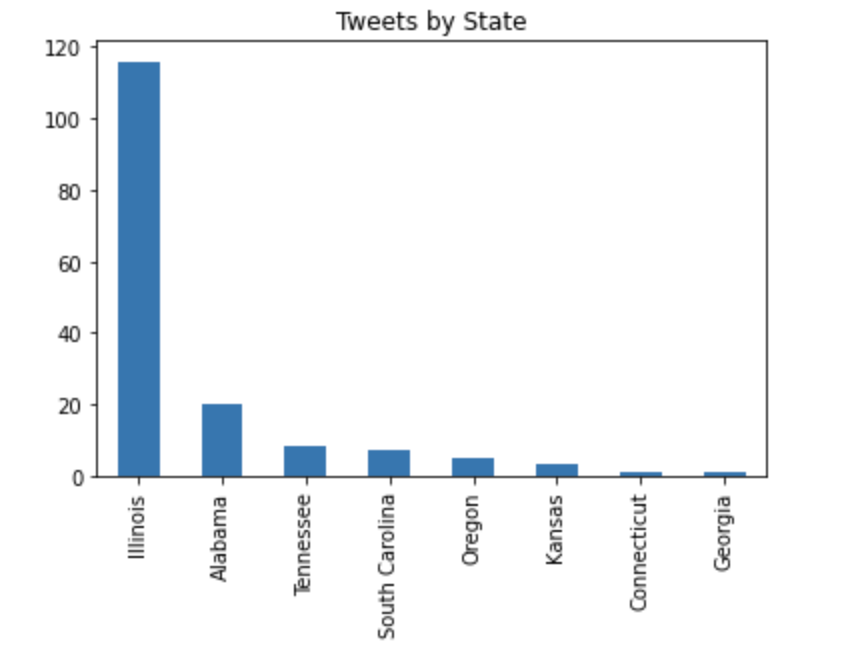